In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
def calStability(raw, task_order, method, normalise=False, raw_acc=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            target = rows[rows["method"]==m]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if normalise:    
                _ideal = offline[offline["task_index"]==1]["accuracy"]
                
                val = float((_m["accuracy"]/float(_ideal)).sum()/len(_m))
                values[m].append(val)
                
            elif raw_acc:
                val = (_m["accuracy"])
                values[m].append(list(val))
                
            else:
                val = float((_m["accuracy"]).sum()/len(_m))
                    
                values[m].append(val)
    
    return values


def calPlasticity(raw, task_order, method, normalise=False, raw_acc=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            train_session = target["train_session"].unique()
            
            for s in train_session:
                s = int(s)
                
                _m = target[target["train_session"]==str(s)]
                _m = _m[_m["task_index"]==s]["accuracy"]
                
                assert len(_m)==1
                if normalise:
                    _ideal = offline[offline["task_index"]==s]["accuracy"]
                    _sum += float(_m)/float(_ideal)
                elif raw_acc:
                    _sum.append(float(_m))
                else:
                    _sum += float(_m)
            
            if raw_acc:
                values[m].append(_sum)
                continue
                
            if len(train_session)==0:
                values[m].append(np.nan)
            else:
                val = _sum/len(train_session)
                values[m].append(val)
    
    return values

def calOverallAcc(raw, task_order, method, normalise=False, raw_acc=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            _m = target[target["train_session"]==str(len(task_index))]
            for t in task_index:
                t = int(t)
                _m1 = _m[_m["task_index"]==t]["accuracy"]
                assert len(_m1)==1

                if normalise:
                    _ideal = offline[offline["task_index"]==t]["accuracy"]
                    _sum += float(_m1)/float(_ideal)
                    
                elif raw_acc:
                    _sum.append(float(_m1))
                    
                else:
                    _sum += float(_m1)

            if raw_acc:
                values[m].append(_sum)
                continue
                
                
            if len(train_session)==0:
                values[m].append(np.nan)
            else:
                val = _sum/len(train_session)
                values[m].append(val)
    
    return values

In [11]:
# Overall accuracy at each step

def calOverallAccEach(raw, task_order, method, normalise=False, raw_acc=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            _m = target[target["train_session"]==str(len(task_index))]
            
            val = []
            for s in train_session:
                s = int(s)
                
                _m = target[target["train_session"]==str(s)]
                _sum = _m["accuracy"].sum()/len(_m)
                val.append(_sum)
            values[m].append(val)
                
    return values

In [12]:
dataset = "CASAS"
folder = "../Results/"+dataset+"/exp_no_of_hidden/"

raw = pd.read_csv(folder+"results.txt")
raw.columns = [c.strip() for c in raw.columns]

cmd = raw["cmd"].unique()
task_order = raw["task_order"].unique()
method = raw["method"].unique()

stability = []
plasticity = []
overallAcc = []
for c in cmd:
    target = raw[raw["cmd"]==c]
    
    stability.append(calStability(target, task_order, method, raw_acc=True))
    plasticity.append(calPlasticity(target, task_order, method, raw_acc=True))
    overallAcc.append(calOverallAccEach(target, task_order, method, raw_acc=True))


# Continual learning 

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plotline(values, label, x=[], models=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams.update({'font.size': 20})
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]

    numbers = []
    for model in models:
        nTaskOrder = len(values[model])
        nTask = len(values[model][0])
        
        _pivot = [[] for i in range(nTask)]
        for i in range(nTaskOrder):
            for j in range(nTask):
                _pivot[j].append(values[model][i][j])
        
        avg = [(np.nanmean(v), stats.sem(v, nan_policy="omit")) for v in _pivot]
        numbers.append(avg)

    fig, ax = plt.subplots()
    
    patterns = [ "-s" , "-o" , "-x" , "-D" , "-+" , "-*", "-2" ]
    for i, model in enumerate(models):
        mval = [v for (v, _) in numbers[i]]
        merr = [e for (_, e) in numbers[i]]
        print(x, model, mval)
        ax.errorbar(x, mval, yerr=merr, fmt=patterns[i])

        mx = [v+e for (v, e) in numbers[i]]
        mn = [v-e for (v, e) in numbers[i]]
        
#         ax.fill_between(x, mn, mx, alpha=0.2)

    ax.set_ylim(ymin=-0.1, ymax=1.1)
    ax.set_title(label)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend(models, prop={'size': 20}, loc=3, bbox_to_anchor=(1, 0.4))
#     ax.legend(prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)


    fig.tight_layout()

    plt.show()

[1, 2, 3, 4, 5] sg-cwgan [0.9433333333333334, 0.7482926421404683, 0.5733772169859126, 0.4949271055031925, 0.40554031113813727]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.00953846153846154, 0.0, 0.0, 0.0]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9239342632005677, 0.841751431539475, 0.8110071070234113, 0.7518124556602818]
[1, 2, 3, 4, 5] lwf [0.9524848484848485, 0.35784103577581844, 0.0981596483226918, 0.07902341137123745, 0.06756521739130435]
[1, 2, 3, 4, 5] ewc [0.9498181818181818, 0.0, 0.0, 0.0, 0.0]


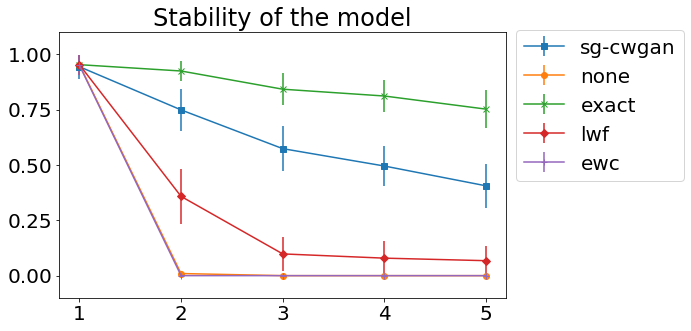

[1, 2, 3, 4, 5] sg-cwgan [0.9433333333333334, 0.9241571004159239, 0.8631471861471862, 0.9867189064558628, 0.9325516838234229]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.9468766798418973, 0.9366943722943724, 0.9977136363636363, 0.9847803030303031]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9238964771830457, 0.9024883116883116, 0.9845672342150603, 0.9728326492348233]
[1, 2, 3, 4, 5] lwf [0.9524848484848485, 0.9105433465085639, 0.880339393939394, 0.9964372859025034, 0.9473517316017317]
[1, 2, 3, 4, 5] ewc [0.9498181818181818, 0.9508766798418972, 0.9506857142857144, 0.9976045454545455, 0.9843041125541125]


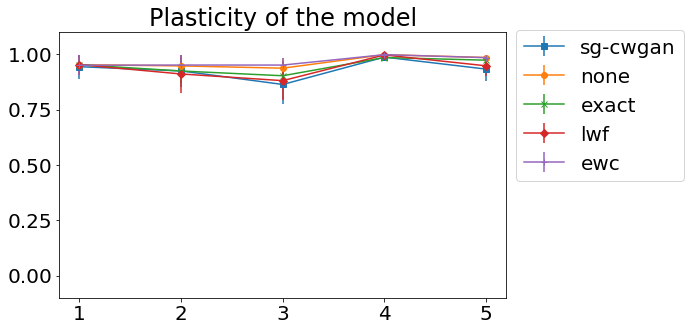

[1, 2, 3, 4, 5] sg-cwgan [0.9433333333333334, 0.8362248712781961, 0.7488804731363334, 0.7230573249305103, 0.6760754031925097]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.4782075706901794, 0.3122314574314574, 0.2526784090909091, 0.19841693017127798]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9239153701918065, 0.8857727595356728, 0.863886243408983, 0.854672230463288]
[1, 2, 3, 4, 5] lwf [0.9524848484848485, 0.6341921911421913, 0.5321102443967467, 0.49034107524624987, 0.44437249081253577]
[1, 2, 3, 4, 5] ewc [0.9498181818181818, 0.4754383399209486, 0.3237648033126294, 0.277217803030303, 0.19686082251082251]


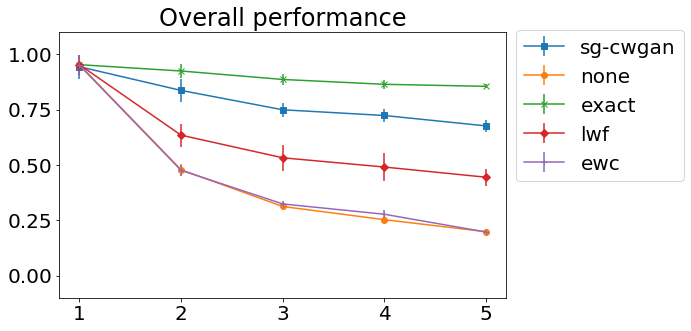

In [24]:

# select the best model (best GAN and best hidden units) => "sg-cwgan" with 500 hidden units
def selectModel(model, cmd):
    models = [ model, "none", "exact", "lwf", "ewc"] # and offline
    plotline(stability[cmd], "Stability of the model", x=[1,2,3,4,5], models=models)
    plotline(plasticity[cmd], "Plasticity of the model", x=[1,2,3,4,5], models=models)
    plotline(overallAcc[cmd], "Overall performance", x=[1,2,3,4,5], models=models)

selectModel("sg-cwgan", 3)



# GAN

In [ ]:
# xticks = [20, 50, 100, 200]      #HouseA
# xticks = [50, 100, 200, 500]     #CASAS
# xticks = [100, 200, 500, 1000]   #PAMAP
# xticks = [100, 200, 500, 1000]     #DSADS

# models = ["mp-gan", "mp-wgan",  "sg-cgan", "sg-cwgan"]
# plotline(overallAcc[0], "Stability of the model", x=[1,2,3,4,5], models=models)
# plotline(overallAcc[1], "Stability of the model", x=[1,2,3,4,5], models=models)
# plotline(overallAcc[2], "Stability of the model", x=[1,2,3,4,5], models=models)
# plotline(overallAcc[3], "Stability of the model", x=[1,2,3,4,5], models=models)